<a href="https://colab.research.google.com/github/blanchelalouette/tpgithub1/blob/master/Cas_Saint_GOBAIN_Pr%C3%A9diction_des_professions_clients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TEST PYTHON : PREDICTION DES PROFESSIONS CLIENTS 

## Blanche LALOUETTE

### Candidature pour un stage en data science




## Consignes : 
- But: Prédire la profession des clients
- Requis:
  - Langage de programmation: Python
  - Librairies: toutes
  - Un code lisible, pouvant donner lieu à discussion.
- Données accessibles:
  - techtest/README.txt : Ce fichier
  - techtest/data/Facturations.csv : facturation des clients
  - techtest/data/Clients.csv : meta données sur les clients 
  - techtest/data/Clients_to_complete.csv : Données manquantes sur les clients - à prédire.
- Note:
  - Ces données sont fausses et ont été générées dans le cadre de ce test.
- A livrer:
  - Un fichier zip contenant:
    - Un code exécutable (dans un dossier ./code/)
    - Un fichier solution.pdf  expliquant les choix et l'explication de la solution développée 
    - Un fichier solution.csv avec une ligne par client du fichier clients_to_complete avec le format suivant: "client_id,predicted_profession"


# Installation des packages nécessaires 

In [74]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ="all"

sns.set_style('whitegrid')

# Importation des données 

In [100]:
from datetime import datetime
facturations = pd.read_csv("Facturations.csv")
#facturations["time"] = facturations['timestamp'].apply(datetime.fromtimestamp)
facturations

,product_id,client_id,timestamp
0,21.0,7.954279e+12,1.486218e+09
1,12.0,1.030792e+13,1.477860e+09
2,3.0,2.843268e+12,1.450139e+09
3,90.0,1.230079e+13,1.479925e+09
4,86.0,1.752347e+12,1.506672e+09
...,...,...,...
80109,56.0,2.293513e+12,1.475233e+09
80110,5.0,1.047972e+12,1.468841e+09
80111,56.0,1.192283e+13,1.446590e+09
80112,43.0,7.352984e+12,1.419129e+09


In [101]:
clients = pd.read_csv("Clients.csv", encoding = 'latin-1', sep=';')
clients

,client_id,Anciennete,Profession
0,13460427505664,142.0,Menuisier
1,4707284156416,259.0,Platrier
2,2525440770048,36.0,Menuisier
3,16973710753795,216.0,Maçon
4,3642132267010,19.0,Menuisier
...,...,...,...
4980,7696581394432,43.0,Platrier
4981,10402410790913,66.0,Maçon
4982,14379550507009,70.0,Menuisier
4983,2508260900866,118.0,Menuisier


In [102]:
clients_to_complete = pd.read_csv("Clients_to_complete.csv", encoding = 'latin-1', sep=';')
clients_to_complete

,client_id
0,240518168577
1,3659312136192
2,4123168604161
3,7456063225858
4,1829656068096
...,...
1260,16372415332352
1261,953482739712
1262,7980049235969
1263,6047313952769


# Statistiques descriptives : appropriation des données

*Afin de s'approprier les données, j'ai choisi de faire quelques graphes descriptifs. L'idée est de voir les caractéristiques des différentes variables, de me rendre compte de ce qui me servira ou non à la modélisation*

### Base clients

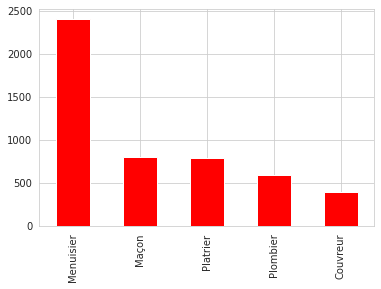

In [103]:
clients['Profession'].value_counts().plot(kind='bar', color='r')

On remarque qu'il y a beaucoup plus de menuisiers. En prévision d'un modèle, il faudra donc rééquilibrer les proporsions de chaque profession pour ne pas fausser la prédiction. 

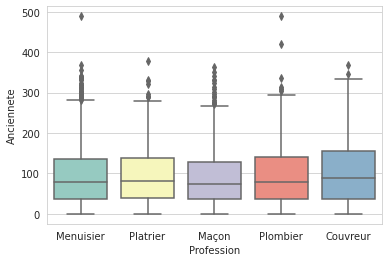

In [79]:
clients_anciennete = clients.copy()
clients_anciennete.drop(["client_id"], axis = 'columns', inplace = True)
ax = sns.boxplot(x="Profession", y="Anciennete", data=clients_anciennete, palette="Set3")

Les données d'ancienneté sont réparties de manières similaires entre les professions, il n'y a pas de grandes divergences. Il apparait donc que la variable ancienneté ne soit pas déterminante pour prédire la profession des clients. 

### Base facturations

In [80]:
len(facturations)
print('Nombre de dates d achat différentes:')
len(pd.unique(facturations["timestamp"]))
print('Nombre de clients différents:')
len(pd.unique(facturations["client_id"]))

80114

Nombre de dates d achat différentes:


57167

Nombre de clients différents:


5974

La base facturations regroupent 5 974 clients sur 80 114 données à 57 167 dates différentes 

(array([3777., 3599., 4165., 3811., 3849., 3857., 4317., 4464., 3731.,
        4305., 4102., 4001., 3874., 3686., 3589., 4274., 4052., 3910.,
        4463., 4220.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <a list of 20 Patch objects>)

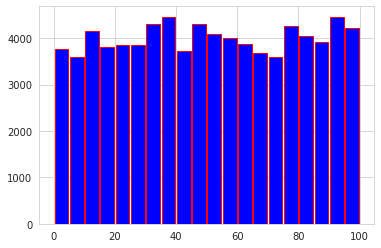

In [81]:
plt.hist(facturations["product_id"],range = (0,100), bins=20,align="mid",rwidth=0.9,color="b",edgecolor="red",label="produits")

En ce qui concerne les différents produits, leur fréquence d'achat varie entre 3500 et 45000. Dans l'ensemble, c'est plutot homogène. Malgré quelques pics, aucun produit ne se distingue largement par rapport aux autres. On suppose également que cette variable ne sera pas déterminante pour la différenciation des professions. 

(array([   36.,    50.,   126.,   517.,  1192.,  2250.,  3969.,  5728.,
         8847., 10622., 11282., 10971.,  9227.,  6506.,  4091.,  1946.,
         1149.,   563.,   212.,    59.]),
 array([0.00000000e+00, 1.13744973e+07, 2.27489946e+07, 3.41234919e+07,
        4.54979892e+07, 5.68724865e+07, 6.82469838e+07, 7.96214811e+07,
        9.09959784e+07, 1.02370476e+08, 1.13744973e+08, 1.25119470e+08,
        1.36493968e+08, 1.47868465e+08, 1.59242962e+08, 1.70617460e+08,
        1.81991957e+08, 1.93366454e+08, 2.04740951e+08, 2.16115449e+08,
        2.27489946e+08]),
 <a list of 20 Patch objects>)

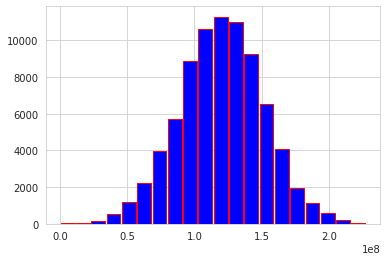

In [82]:
facturations['timestamp']=facturations['timestamp']-min(facturations['timestamp'])
plt.hist(facturations["timestamp"],range = (0,max(facturations['timestamp'])), bins=20,align="mid",rwidth=0.9,color="b",edgecolor="red",label="timestamp")

La variable timestamp n'étant pas exprimée en date, et la commande de transformation de timestamp en date ne fonctionnant pas, j'ai décidé de fixé un début à la première donnée d'achat et d'observer la répartition de toutes les données à partir de ce premier achat modélisé en t=0. Ce qu'on peut voir, c'est que la fréquence des achats ressemble à une loi normale et donc parait plus aléatoire. 


### Comparaison et fusion des bases 

*Regroupons toutes les données et les informations de façon à avoir un data frame propre pour notre modélisation*

In [83]:
fusion = pd.merge(clients,facturations, on=['client_id'], how ='outer')
fusion

print('Nombre de clients différents:')
len(pd.unique(fusion["client_id"]))

,client_id,Anciennete,Profession,product_id,timestamp
0,1.346043e+13,142.0,Menuisier,5.0,149398419.0
1,1.346043e+13,142.0,Menuisier,92.0,151336821.0
2,1.346043e+13,142.0,Menuisier,60.0,208942234.0
3,1.346043e+13,142.0,Menuisier,68.0,143765390.0
4,1.346043e+13,142.0,Menuisier,57.0,114260889.0
...,...,...,...,...,...
80330,1.345184e+13,NaN,NaN,99.0,118138155.0
80331,1.345184e+13,NaN,NaN,99.0,118138155.0
80332,1.114115e+13,NaN,NaN,82.0,160840408.0
80333,1.114115e+13,NaN,NaN,82.0,160840408.0


Nombre de clients différents:


6195

In [84]:
fusion_propre = fusion.drop_duplicates('client_id')
fusion_propre = fusion_propre.dropna(axis=0, how='any')
fusion_propre
print('Nombre de clients par profession:')
fusion_propre['Profession'].value_counts()

,client_id,Anciennete,Profession,product_id,timestamp
0,1.346043e+13,142.0,Menuisier,5.0,149398419.0
13,4.707284e+12,259.0,Platrier,14.0,107604192.0
28,2.525441e+12,36.0,Menuisier,83.0,88294511.0
35,1.697371e+13,216.0,Maçon,9.0,90070593.0
41,3.642132e+12,19.0,Menuisier,53.0,95659065.0
...,...,...,...,...,...
64495,1.232656e+13,50.0,Plombier,64.0,80660725.0
64497,7.696581e+12,43.0,Platrier,28.0,115722811.0
64510,1.040241e+13,66.0,Maçon,2.0,198830105.0
64516,1.437955e+13,70.0,Menuisier,31.0,98079777.0


Nombre de clients par profession:


Menuisier    2145
Maçon         751
Platrier      723
Plombier      506
Couvreur      356
Name: Profession, dtype: int64

Encore une fois, il apparait clairement que nos classes de professions ne sont pas équilibrées. Avant de commencer la modélisation, il faudra donc faire du downsiding pour les menuisiers, et du up siding pour les autres afin de ramener chaque catégorie de profession à 800 individus.  Le choix de 800 vient de la volonté de ne pas trop up sider pour éviter que le modèle soit faussé par des memes données présentes dans le test et dans le train. 

# Modèle prédictif

In [85]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
psi = PolynomialFeatures(2,include_bias=False).fit_transform

## Up and downsampling

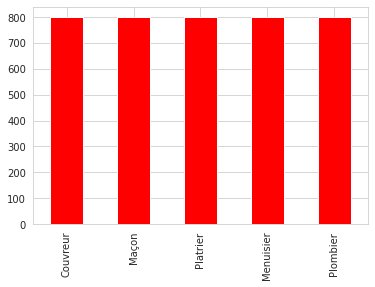

In [86]:
df_class_0 = fusion_propre[fusion_propre['Profession'] == 'Menuisier']
df_class_1 = fusion_propre[fusion_propre['Profession']  == 'Maçon']
df_class_2 = fusion_propre[fusion_propre['Profession'] == 'Platrier']
df_class_3 = fusion_propre[fusion_propre['Profession'] == 'Plombier']
df_class_4 = fusion_propre[fusion_propre['Profession'] == 'Couvreur']

nb_classe = 800
df_class_0_down = df_class_0.sample(n= nb_classe, replace = False)
df_class_1_down = df_class_1.sample(n= nb_classe, replace = True)
df_class_2_down = df_class_2.sample(n= nb_classe, replace = True)
df_class_3_down = df_class_3.sample(n= nb_classe, replace = True)
df_class_4_down = df_class_4.sample(n= nb_classe, replace = True)

df_under = pd.concat([df_class_0_down, df_class_1_down, df_class_2_down,df_class_3_down,df_class_4_down], axis=0)

df_under['Profession'].value_counts().plot(kind='bar', color='r')

Les classes sont donc désormais de meme taille = 1000 individus. Nous pouvons désormais constuire un modèle de machine learning. 

Sachant que les seules informations que l'on a sur le clients_to_complete sont les client_id et au vues des résultats des statistiques descriptives, je préfère n'utiliser qu'une variable explicative (client_id) pour prédire ma variable d'intérêt (Profession) 

In [87]:
X = df_under[['client_id']].values
y = df_under[['Profession']]
from sklearn import preprocessing
X = preprocessing.scale(X)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [88]:
#séparation de la base en train et test : on entraine le modèle sur les train (80%) et on test le modèle sur le reste (20%)
cut = int(X.shape[0]*0.8)
from sklearn.utils import shuffle
X, y = shuffle(X,y)
X_train = X[:cut]
y_train = y[:cut]
X_test = X[cut:]
y_test = y[cut:]

*Nous sommes désormais prêts à tester deux méthodes de classifiers : KNeighbors et une regression logistique multinomiale. Nous choisirons ensuite la plus performante*

## KNeighbors Classifers

In [89]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [90]:
print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

1.0
0.6575


In [91]:
tmp = knn.predict(X_test.reshape(-1,1))

c =0
for i in range(len(tmp)):
    if tmp[i] == y_test.values[i][0]:
        c +=1
print(c)
print(len(y_test.values))

526
800


In [92]:
print(knn.predict(X_test[0].reshape(-1,1)))
print(y_test.values[0])

print(knn.predict(X_test[11].reshape(-1,1)))
print(y_test.values[11])

['Couvreur']
['Couvreur']
['Maçon']
['Platrier']


In [ ]:
indexes = np.arange(0, 50, 1)
SCORE = []
SCORE_test = []

for i in indexes:
    knn_tmp= KNeighborsClassifier(n_neighbors=i+1)
    knn_tmp.fit(X_train, y_train.values.ravel())
    SCORE.append(knn_tmp.score(X_train, y_train))
    SCORE_test.append(knn_tmp.score(X_test, y_test))

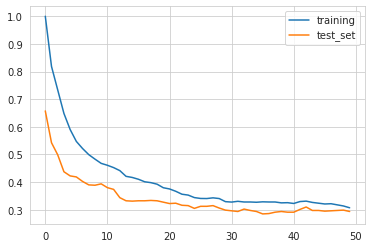

In [94]:
plt.plot(indexes, SCORE, label='training')
plt.plot(indexes, SCORE_test, label='test_set')
plt.legend()
plt.show()

Notre modèle est donc efficace à 60% pour un très petit nombre de voisins. Voyons ce qu'il en est de la regression logistique. 

## Regression logistique multinomiale 

In [95]:
modele_regLog = linear_model.LogisticRegression(random_state = 0, solver = 'lbfgs', multi_class = 'auto')
#training
modele_regLog.fit(X_train,y_train.values.ravel())
#précision du modèle
precision = modele_regLog.score(X_test,y_test)
print('\n',precision*100)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


 22.25


In [96]:
print(modele_regLog.score(X_train, y_train))
print(modele_regLog.score(X_test, y_test))

0.218125
0.2225


In [97]:
print(modele_regLog.predict(X_train[0].reshape(-1,1)))
print(y_train.values[0])

['Platrier']
['Maçon']


On s'apercoit que le prédicteur de la regression logistique n'est pas du tout efficace, on va donc garder celui du Knn. 

# Prediction Finale

*On utilise donc notre prédicteur knn, tout en sachant qu'il est efficace à 60%, pour prédire les professions des clients suivants*

In [98]:
X_tocomplete = clients_to_complete.values
jobs = knn.predict(X_tocomplete.reshape(-1,1))
clients_to_complete.insert(1, 'Profession', jobs)
clients_to_complete

,client_id,Profession
0,240518168577,Maçon
1,3659312136192,Maçon
2,4123168604161,Maçon
3,7456063225858,Maçon
4,1829656068096,Maçon
...,...,...
1260,16372415332352,Maçon
1261,953482739712,Maçon
1262,7980049235969,Maçon
1263,6047313952769,Maçon
